In [1]:
from numpy import mean
from numpy import std
import numpy as np
from sklearn.model_selection import cross_val_score , cross_validate ,RepeatedKFold ,GridSearchCV ,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor ,RandomForestRegressor
from sklearn.metrics import r2_score ,mean_absolute_error
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import pandas as pd
import csv

from ipynb.fs.full.set_up import data_prep


Prep
(58437, 24)
CatBoostRegressor--- mae: 344183.8521006044
            r2_score: 0.7894800450341839


[12:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "logging_level", "model__learning_rate", "model__max_depth", "model__n_estimators" } are not used.

XGBRegressor--- mae: 371650.7313899537
            r2_score: 0.7804819745964763


RandomForestRegressor--- mae: 365022.0372753383
            r2_score: 0.777917576143733


knn--- mae: 411624.7612532045
            r2_score: 0.7210248721526651


[12:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "logging_level", "model__learning_rate", "model__max_depth", "model__n_estimators" } are not used.

[12:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgb

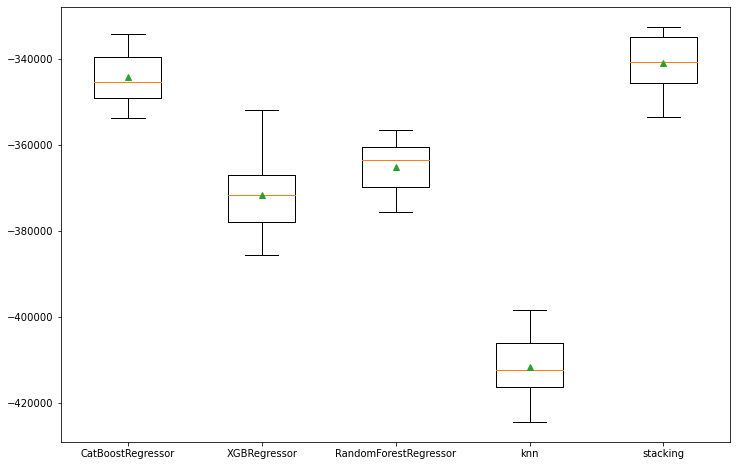

In [2]:

def get_stacking(params):
    # define the base models
    level0 = list()
    level0.append(('CatBoostRegressor', CatBoostRegressor(**params['catboost_params'], logging_level='Silent'))) 
    level0.append(('RandomForestRegressor', RandomForestRegressor(**params['forest_params'])))
    level0.append(('XGBRegressor', XGBRegressor(**params['xgboost_params'], logging_level='Silent')))
    level0.append(('LinearRegression', LinearRegression(**params['linear_params'])))
#     level0.append(('MLPRegressor', MLPRegressor(hidden_layer_sizes=(100, 50),
#                                                 activation='relu', solver='adam', **params['mlp_params'])))


     # define meta-learner model
    level1 = LinearRegression(**params['linear_params'])
#     level1 = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', **params['mlp_params'])

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models(params):
    models = dict()
    
    models['CatBoostRegressor'] = CatBoostRegressor(**params['catboost_params'], logging_level='Silent')
    models['XGBRegressor'] = XGBRegressor(**params['xgboost_params'], logging_level='Silent')
    models['RandomForestRegressor'] = RandomForestRegressor(**params['forest_params'])
#     models['MLPRegressor'] = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', **params['mlp_params'])
#     models['LinearRegression'] = LinearRegression(**params['linear_params'])
    models['knn'] = KNeighborsRegressor()
    
    models['stacking'] = get_stacking(params)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model,X_train_scaled, X_test_scaled  ,y_train, y_test):
    model_train = model.fit(X_train_scaled , y_train)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model_train, X_test_scaled, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    mae = -scores.mean()
    r2 = model_train.score(X_test_scaled, y_test)
    
    return mae ,r2 , scores
 
forest_params= {'n_estimators': 200,
                  'min_samples_split': 2,
                  'min_samples_leaf': 2, 
                  'max_features': 'sqrt', 
                  'max_depth': 15, 
                  'bootstrap': False}

xgboost_params = {'model__learning_rate': 0.1,
                  'model__max_depth': 7, 
                  'model__n_estimators': 250}

catboost_params = {'iterations': 1500,
                   'learning_rate': 0.05,
                   'l2_leaf_reg': 3,
                   'depth': 8}

linear_params = {'fit_intercept': True,
                 'normalize': True}

mlp_params = {'alpha': 0.01,
              'learning_rate_init': 0.001}

params = {'forest_params': forest_params , 'xgboost_params':xgboost_params
          ,'catboost_params':catboost_params ,'linear_params':linear_params,'mlp_params':mlp_params }


X_train_scaled,  X_test_scaled  ,y_train, y_test , X_train, X_test = data_prep()

# get the models to evaluate
models = get_models(params)

# evaluate the models and store results
scores, names = list(), list()
for name, model in models.items():
    mae ,r2 , score = evaluate_model(model, X_train_scaled , X_test_scaled  ,y_train, y_test)
    print(f"{name}--- mae: {mae}\n            r2_score: {r2}\n\n") 
    scores.append(score)
    names.append(name)
#     print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# plot model performance for comparison
pyplot.figure(figsize=(12,8)) 
pyplot.boxplot(scores, labels=names, showmeans=True)
pyplot.show()